In [14]:
%load_ext autoreload
%autoreload all
import numpy as np
import pandas as pd
from faker import Faker
from custom_providers import dates, names_and_tickers, price_columns, sectors
from calculated_columns.moving_average import calculate_moving_average
from calculated_columns.macd import calculate_macd
from utilities.missing_values import add_missing_values_to_df
from utilities.capitalize_words import capitalize_words_and_remove_und_scr
import matplotlib.pyplot as plt
import talib
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Specify number of rows and price range
num_rows = 1140
time_period_in_days = 114

# Add custom providers
fake = Faker()
fake.add_provider(dates.Dates)
fake.add_provider(names_and_tickers.NamesAndTickers)
fake.add_provider(price_columns.PriceColumns)
fake.add_provider(sectors.Sectors)

In [16]:
# Generate values for initial columns
date_df = fake.generate_dates(time_period_in_days=time_period_in_days,
                              num_rows=num_rows,)

# name_prob_dict = {"Company": 0.1, "Ticker": 0.1}
name_ticker_df = fake.generate_names_and_tickers(
    time_period_in_days=time_period_in_days,
    num_rows=num_rows
)#, **name_prob_dict)

sector_df = fake.generate_sectors(
    num_rows=num_rows,
    time_period_in_days=time_period_in_days
)

# price_prob_dict = {
#     "Open Price": 0.1,
#     "Close Price": 0.1,
#     "High Price": 0.1,
#     "Low Price": 0.1,
#     "Volume": 0.1
# }

price_df = fake.generate_prices(
    num_of_companies=10,
    sample_size=num_rows,
    num_of_days=time_period_in_days
)

In [17]:
df = pd.concat([date_df, name_ticker_df, sector_df, price_df], axis=1)
df.head()

,Date,Company,Ticker,Sector,Close Price,Open Price,High Price,Low Price,Volume
0,2023-01-30,Heath-Gates,HGOEE,Finance,771.448168,776.650016,825.167290,692.720563,916322
1,2023-01-31,Heath-Gates,HGOEE,Finance,564.368098,551.093350,590.772183,461.604717,933554
2,2023-02-01,Heath-Gates,HGOEE,Finance,312.288478,303.613703,343.959481,299.143845,259730
3,2023-02-02,Heath-Gates,HGOEE,Finance,91.188490,93.132107,176.651966,72.424278,173136
4,2023-02-03,Heath-Gates,HGOEE,Finance,366.805903,371.307569,404.588332,306.628333,523463


In [18]:
window_size = 10

def calculate_technical_indicators(group_df):
    group_df['RSI'] = talib.RSI(group_df['Close Price'], timeperiod=14)
    group_df['Upper_Band'], _, group_df['Lower_Band'] = talib.BBANDS(group_df['Close Price'], timeperiod=window_size, nbdevup=2, nbdevdn=2)
    return group_df

df['Rolling Mean'] = df.groupby('Company')['Close Price'].rolling(window_size).mean().reset_index(level=0, drop=True).values
df = df.groupby('Company').apply(calculate_technical_indicators).reset_index(drop=True)

In [19]:
df.isnull().sum()

Date              0
Company           0
Ticker            0
Sector            0
Close Price       0
Open Price        0
High Price        0
Low Price         0
Volume            0
Rolling Mean     90
RSI             140
Upper_Band       90
Lower_Band       90
dtype: int64

In [20]:
df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [21]:
df.isnull().sum()

Date            0
Company         0
Ticker          0
Sector          0
Close Price     0
Open Price      0
High Price      0
Low Price       0
Volume          0
Rolling Mean    0
RSI             0
Upper_Band      0
Lower_Band      0
dtype: int64

In [22]:
df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)

In [23]:
# Check if open and close prices are higher or lower than high and low prices
condition_high = (df['open_price'] > df['high_price']) | (df['close_price'] > df['high_price'])
condition_low = (df['open_price'] < df['low_price']) | (df['close_price'] < df['low_price'])

result = condition_low | condition_high

filtered_df = df[result]
print(len(filtered_df))

0


## Time Series Analysis

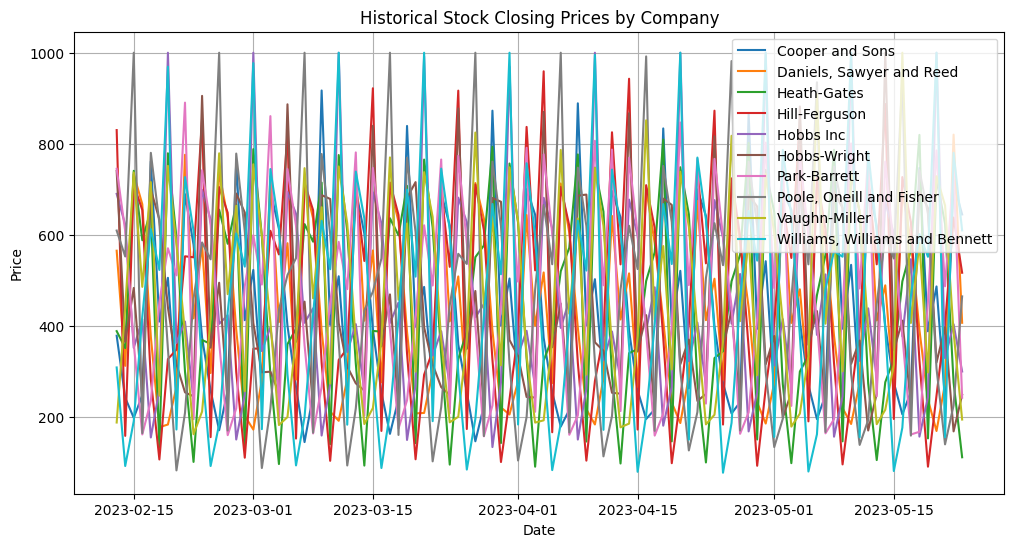

In [24]:
df['date'] = pd.to_datetime(df['date'])

# Plotting by company
companies = df['company'].unique()
plt.figure(figsize=(12, 6))

for company in companies:
    company_data = df[df['company'] == company]
    plt.plot(company_data['date'], company_data['close_price'], label=company)

plt.title('Historical Stock Closing Prices by Company')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
for company in df['company'].unique():
    print(company)

Cooper and Sons
Daniels, Sawyer and Reed
Heath-Gates
Hill-Ferguson
Hobbs Inc
Hobbs-Wright
Park-Barrett
Poole, Oneill and Fisher
Vaughn-Miller
Williams, Williams and Bennett


In [26]:
import plotly.graph_objects as go


for company in df['company'].unique():
    filtered_df = df[df['company'] == company]

    fig = go.Figure(data=[go.Candlestick(x=filtered_df['date'],
                                        open=filtered_df['open_price'],
                                        high=filtered_df['high_price'],
                                        low=filtered_df['low_price'],
                                        close=filtered_df['close_price'])
                                        ])
    
    fig.update_layout(
        title=f"{company} Stock Price Chart",
        yaxis_title="Price"
    )

    fig.show()

/Users/bekajaparidze/Desktop/fake_stock_data/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


/Users/bekajaparidze/Desktop/fake_stock_data/.venv/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



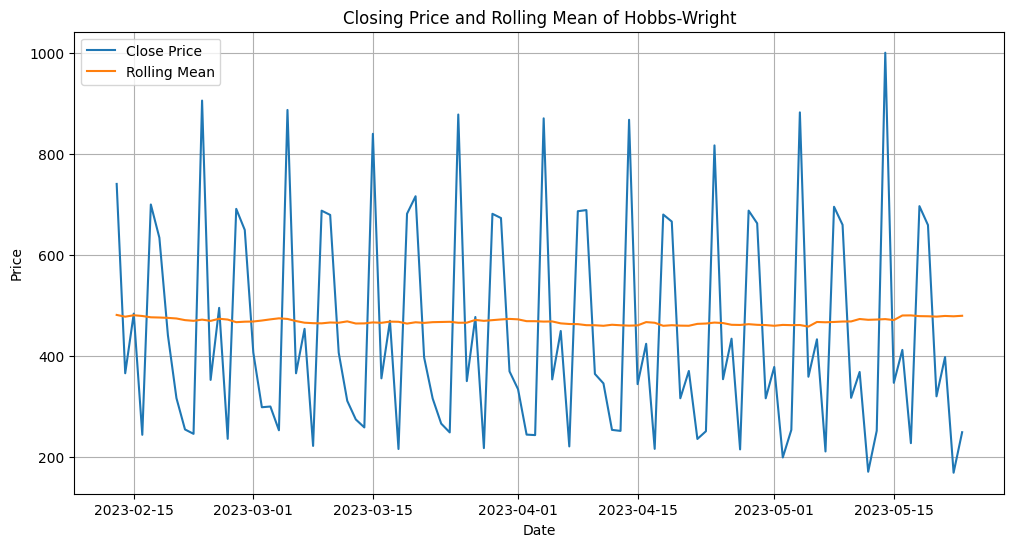

In [27]:
import random

plt.figure(figsize=(12, 6))

company = random.choice(df["company"].unique())

company_data = df[df['company'] == company]
plt.plot(company_data['date'], company_data['close_price'], label='Close Price')
plt.plot(company_data['date'], company_data['rolling_mean'], label='Rolling Mean')

plt.title(f'Closing Price and Rolling Mean of {company}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(visible=True)
plt.show()

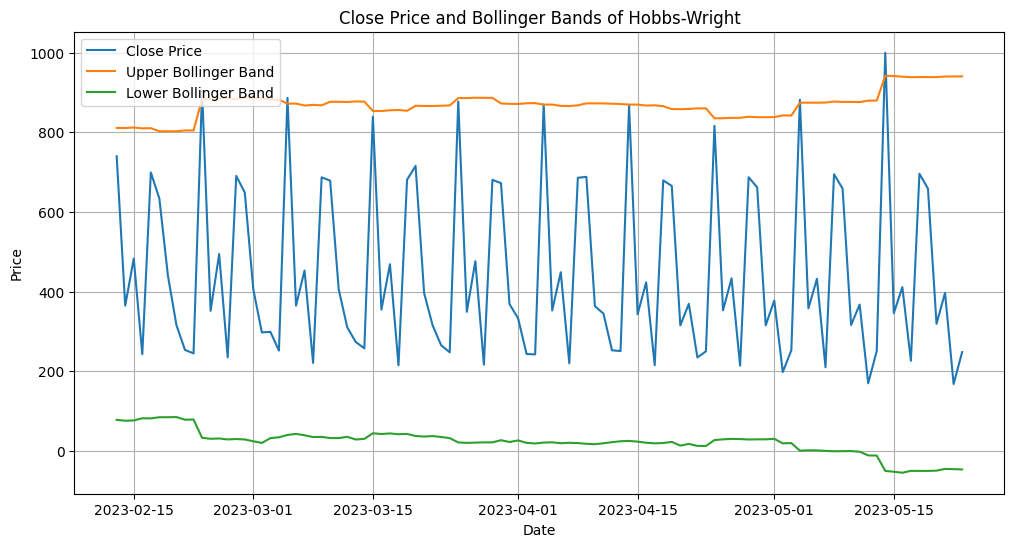

In [28]:
plt.figure(figsize=(12, 6))

plt.plot(company_data['date'], company_data['close_price'], label='Close Price')
plt.plot(company_data['date'], company_data['upper_band'], label='Upper Bollinger Band')
plt.plot(company_data['date'], company_data['lower_band'], label='Lower Bollinger Band')

plt.title(f'Close Price and Bollinger Bands of {company}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

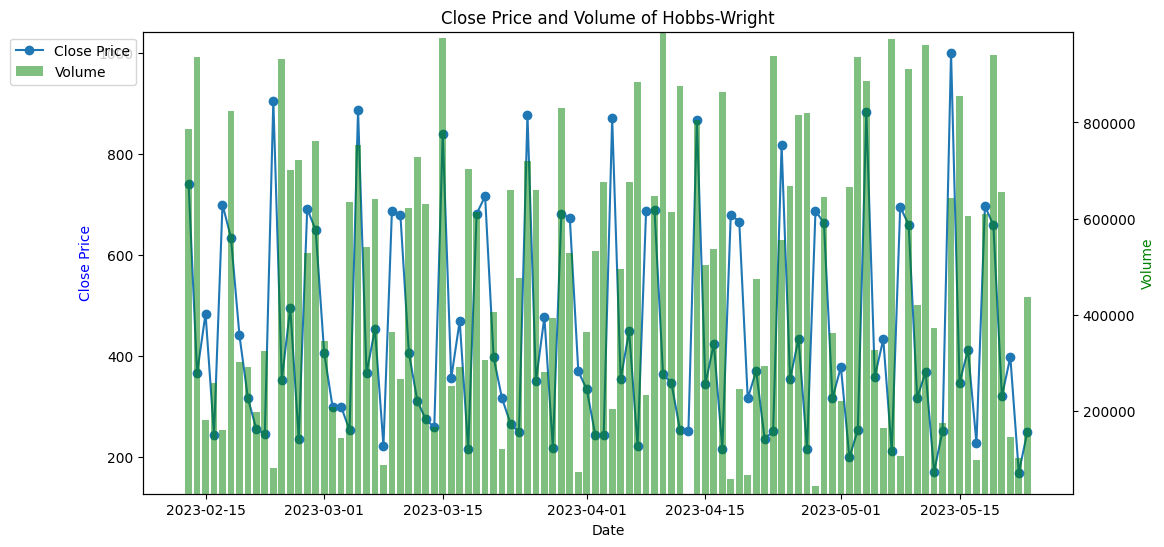

In [29]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(company_data['date'], company_data['close_price'], label='Close Price', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')

ax2 = ax1.twinx()
ax2.bar(company_data['date'], company_data['volume'], label='Volume', color='green', alpha=0.5)
ax2.set_ylabel('Volume', color='green')

min_volume_value = min(company_data['volume'])
max_volume_value = max(company_data['volume'])
ax2.set_ylim(min_volume_value, max_volume_value)

line1, labels1 = ax1.get_legend_handles_labels()
bar2, labels2 = ax2.get_legend_handles_labels()
lines = line1 + bar2
labels = labels1 + labels2

by_label = dict(zip(labels, lines))

plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0,1))

plt.title(f'Close Price and Volume of {company}')
plt.xlabel('Date')
plt.show()

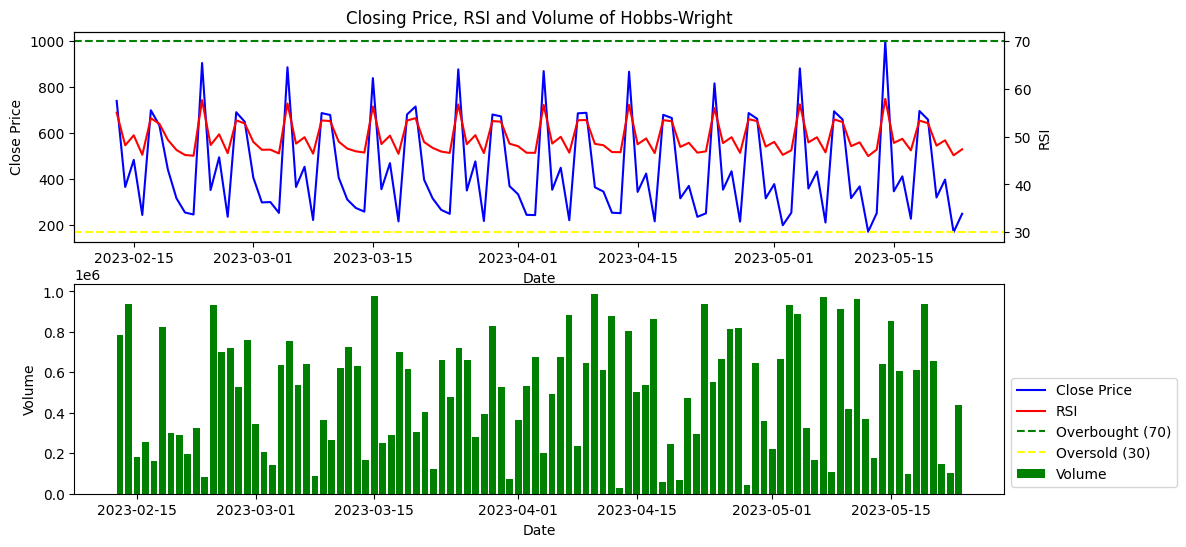

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax1: plt.Axes = ax[0]
ax3: plt.Axes = ax[1]

ax1.plot(company_data['date'], company_data['close_price'], label='Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price')

ax2 = ax1.twinx()
ax2.plot(company_data['date'], company_data['rsi'], label='RSI', color='red')
ax2.set_ylabel('RSI')

ax2.axhline(y=70, color='green', linestyle='--', label='Overbought (70)')
ax2.axhline(y=30, color='yellow', linestyle='--', label='Oversold (30)')

ax3.bar(company_data['date'], company_data['volume'], label='Volume', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('Volume')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
bars3, labels3 = ax3.get_legend_handles_labels()
lines = lines1 + lines2 + bars3
labels = labels1 + labels2 + labels3

by_label = dict(zip(labels, lines))

ax3.legend(by_label.values(), by_label.keys(), loc='lower left', bbox_to_anchor=(1, 0))

plt.title(f"Closing Price, RSI and Volume of {company}")
plt.show()

## By Sector Comparative Analysis

In [35]:
sector_groups = df.groupby("sector")["company"].unique()
print(sector_groups.apply(len))
for sector, companies in sector_groups.items():
    print(f"Sector: {sector}, count: {len(companies)}, Companies: {companies}")

sector
Consumer Goods    3
Energy            1
Finance           2
Healthcare        1
Technology        3
Name: company, dtype: int64
Sector: Consumer Goods, count: 3, Companies: ['Cooper and Sons' 'Daniels, Sawyer and Reed' 'Hobbs-Wright']
Sector: Energy, count: 1, Companies: ['Williams, Williams and Bennett']
Sector: Finance, count: 2, Companies: ['Heath-Gates' 'Hill-Ferguson']
Sector: Healthcare, count: 1, Companies: ['Park-Barrett']
Sector: Technology, count: 3, Companies: ['Hobbs Inc' 'Poole, Oneill and Fisher' 'Vaughn-Miller']


In [60]:
def plot_line_graph_by_sector(df: pd.DataFrame, column_on_x: str, column_on_y: str):
    # Group by sector and filter sectors with more than one company
    sector_groups = df.groupby("sector")["company"].unique()
    duplicate_sector_companies = sector_groups[sector_groups.apply(len) > 1]
    
    # Iterate through sectors
    for sector, companies in duplicate_sector_companies.items():
        # Filter the DataFrame for the current sector
        df_by_sector = df[df["sector"] == sector]
        
        # Create a new figure for each sector
        plt.figure(figsize=(12,6))
        
        # Iterate through companies within the sector
        for company in companies:
            # Filter the DataFrame for the current company within the sector
            df_by_company = df_by_sector[df_by_sector["company"] == company]
            
            plt.plot(df_by_company[column_on_x], df_by_company[column_on_y], label=company, marker='o')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        
        x_label = capitalize_words_and_remove_und_scr(column_on_x)
        y_label = capitalize_words_and_remove_und_scr(column_on_y)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f"{y_label} Comparison in {sector}")
        plt.legend(by_label.values(), by_label.keys())
        plt.grid(True)

    plt.show()


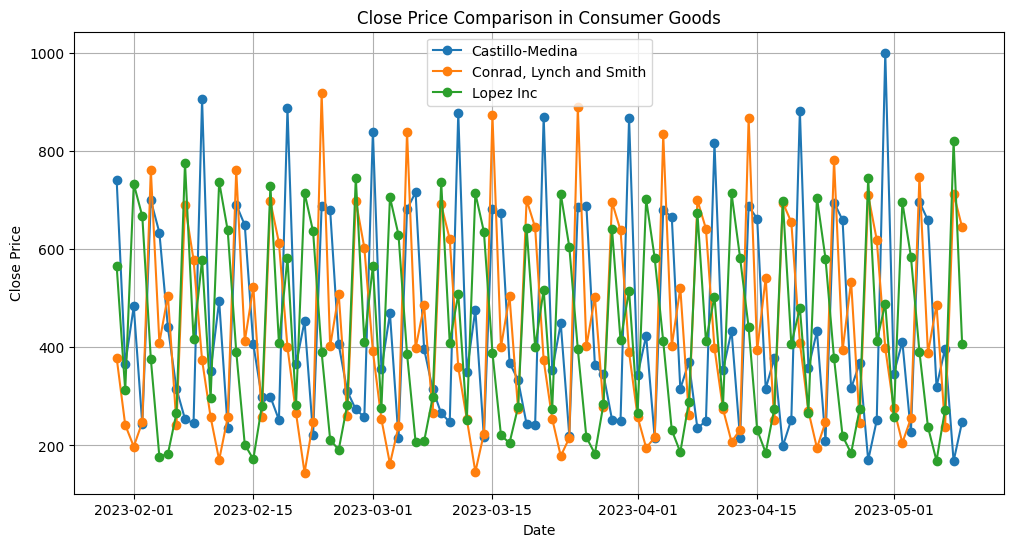

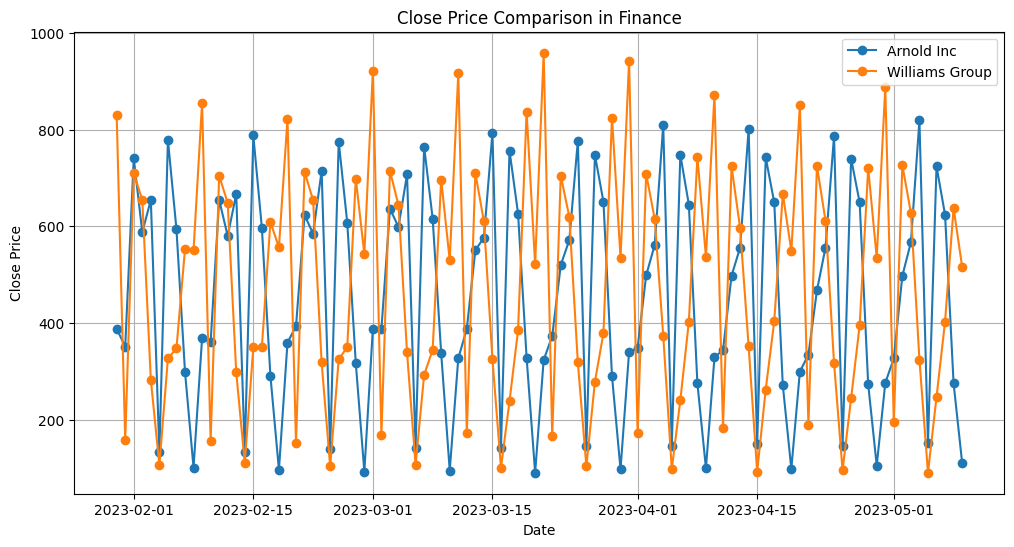

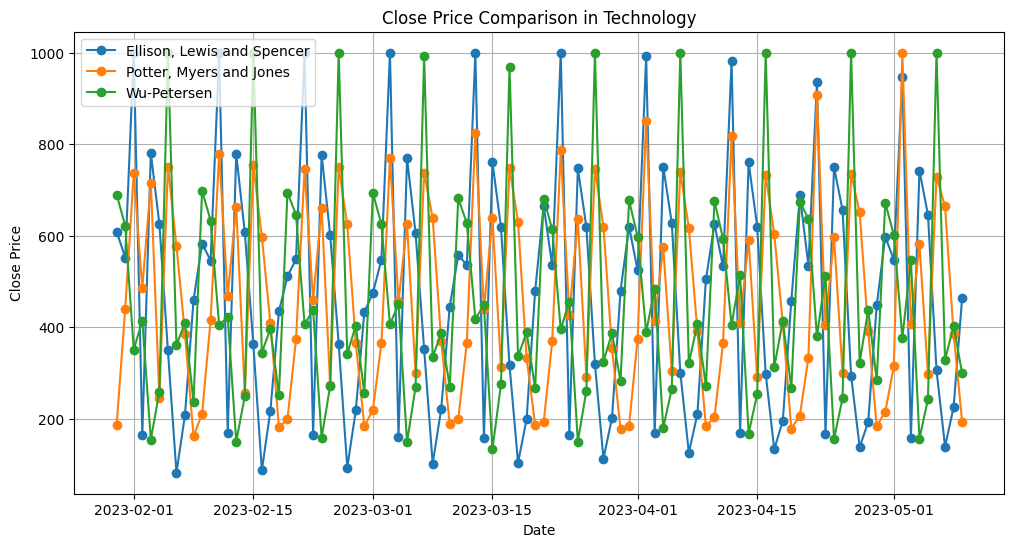

In [61]:
plot_line_graph_by_sector(df, "date", "close_price")

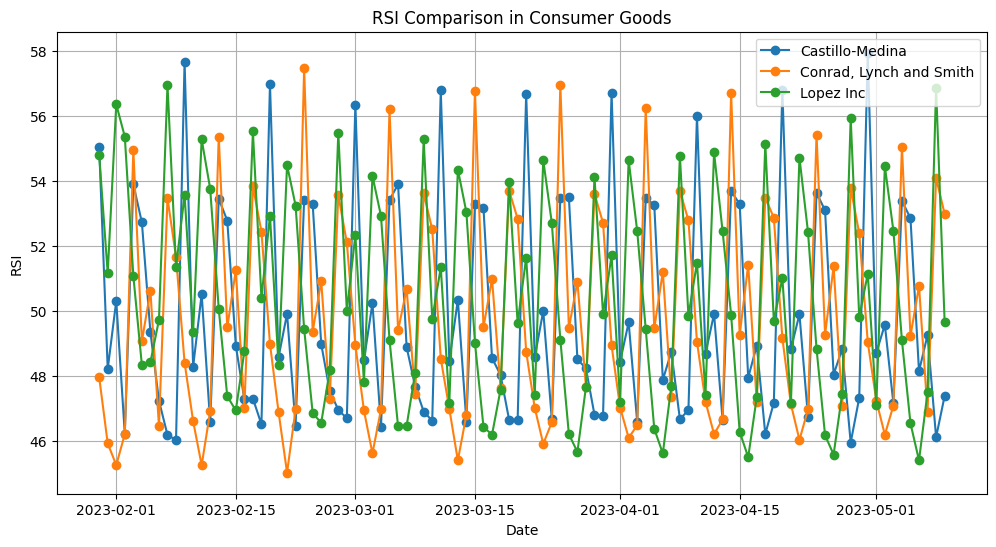

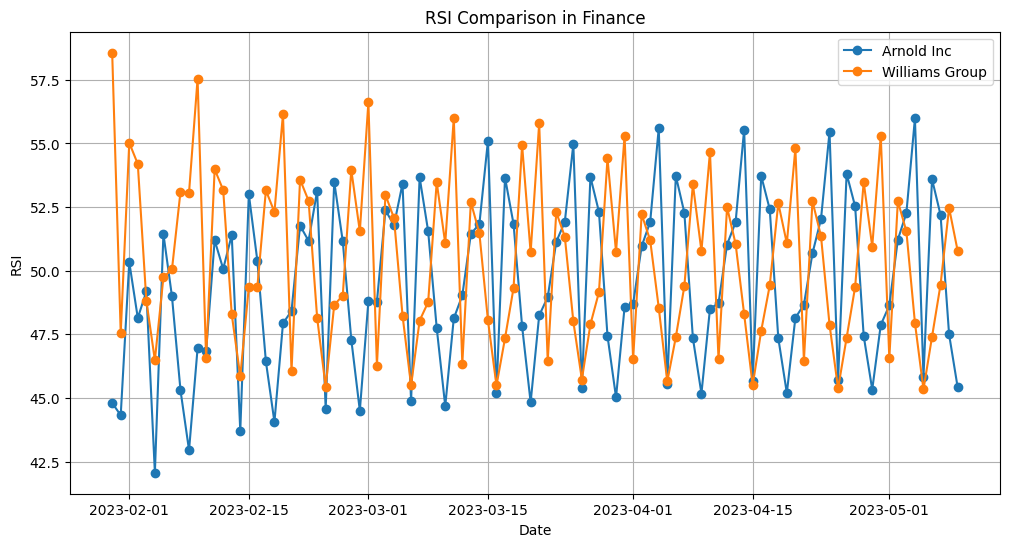

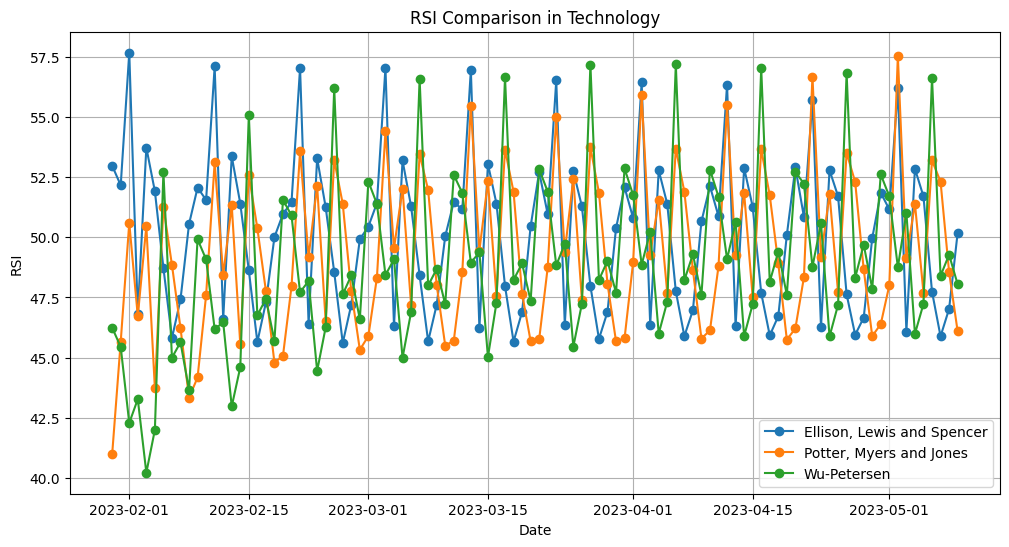

In [62]:
plot_line_graph_by_sector(df, "date", "rsi")